In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S,preprocess_input
from tensorflow.keras.applications.xception import Xception,preprocess_input
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
import tensorflow.keras.layers  as layers
from tensorflow.keras.optimizers import Adam
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from time import perf_counter, sleep

import tensorflow_addons as tfa


In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=120, 
                                   horizontal_flip = True,)
# width_shift_range=[-150, 150] 사진 자르기 ---- height_shift_range=[-150, 150] 높이 기준으로 자르기
# rotation_range=120 회전하기 ---- brightness_range=[0.1, 1.5] 색 바꾸기 0.1은 10%
# zoom_range=[0.3, 1.5] 확대 ---- shear_range=50 좌우 늘리기
print("start")

test_datagen = ImageDataGenerator(rescale = 1./255)

# Generate training and test sets
train_set = train_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/train',
                                                #  target_size = (224,224),
                                                 target_size = (299,299),
                                                 batch_size = 32,
                                                #  batch_size = 128,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/test',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')

val_set = test_datagen.flow_from_directory(r'/content/drive/MyDrive/테스트용/val',
                                            # target_size = (224,224),
                                            target_size = (299,299),
                                            batch_size = 32,
                                            # batch_size = 128,
                                            class_mode = 'categorical')
print("end")

start
Found 221 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
Found 73 images belonging to 8 classes.
end


In [ ]:
# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionV3(weights='imagenet', include_top=False,input_tensor=input_tensor)

# freezen the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(8, activation='softmax')(x)

# compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
optimizer = Adam(lr = 0.0001), # ★change
loss='categorical_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tfa.metrics. F1Score(num_classes = 8,average='macro')]
                )


In [ ]:
# fit the model
start = perf_counter()
history = model.fit(train_set, epochs = 9, validation_data = val_set) # ★change # ★change # ★change
end = perf_counter()

# print the learning time
print(f"Time : {end-start}")

Epoch 1/9
7/7 [==============================] - 19s 2s/step - loss: 2.5941 - accuracy: 0.2262 - precision_2: 0.3571 - recall_2: 0.1131 - f1_score: 0.2197 - val_loss: 1.6792 - val_accuracy: 0.3288 - val_precision_2: 0.3462 - val_recall_2: 0.1233 - val_f1_score: 0.3351
Epoch 2/9
7/7 [==============================] - 12s 2s/step - loss: 1.7262 - accuracy: 0.3620 - precision_2: 0.4524 - recall_2: 0.2579 - f1_score: 0.3588 - val_loss: 1.2424 - val_accuracy: 0.5616 - val_precision_2: 0.7568 - val_recall_2: 0.3836 - val_f1_score: 0.5370
Epoch 3/9
7/7 [==============================] - 12s 2s/step - loss: 1.0941 - accuracy: 0.6335 - precision_2: 0.7812 - recall_2: 0.4525 - f1_score: 0.6363 - val_loss: 0.8987 - val_accuracy: 0.6849 - val_precision_2: 0.9762 - val_recall_2: 0.5616 - val_f1_score: 0.6815
Epoch 4/9
7/7 [==============================] - 12s 2s/step - loss: 0.8455 - accuracy: 0.6878 - precision_2: 0.8857 - recall_2: 0.5611 - f1_score: 0.6816 - val_loss: 0.8247 - val_accuracy: 0.6

In [ ]:
list(history.history.keys())


['loss',
 'accuracy',
 'precision_2',
 'recall_2',
 'f1_score',
 'val_loss',
 'val_accuracy',
 'val_precision_2',
 'val_recall_2',
 'val_f1_score']

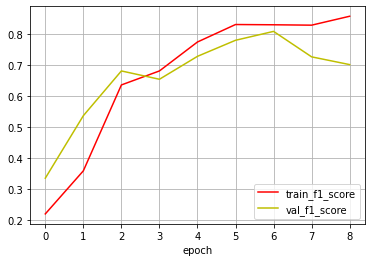

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history[str(list(history.history.keys())[4])] , "r", label='train_f1_score')
plt.plot(history.history[str(list(history.history.keys())[9])] , "y", label='val_f1_score')

plt.xlabel('epoch')

plt.legend(loc='lower right')
plt.grid()
plt.show()

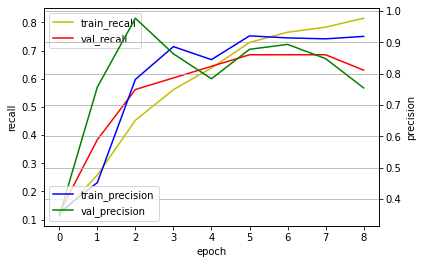

In [ ]:

fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history[str(list(history.history.keys())[3])], 'y', label='train_recall') #3
f1.plot(history.history[str(list(history.history.keys())[8])], 'r', label='val_recall') #8

prec.plot(history.history[str(list(history.history.keys())[2])], 'b', label='train_precision') #2
prec.plot(history.history[str(list(history.history.keys())[7])], 'g', label='val_precision') #-3

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

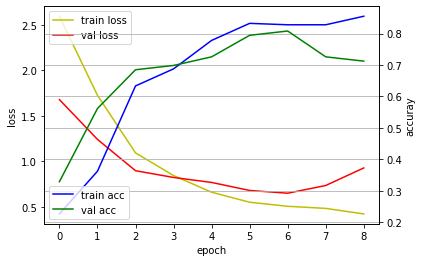

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history[str(list(history.history.keys())[0])], 'y', label='train loss') #3
loss.plot(history.history[str(list(history.history.keys())[5])], 'r', label='val loss') #8

acc.plot(history.history[str(list(history.history.keys())[1])], 'b', label='train acc') #2
acc.plot(history.history[str(list(history.history.keys())[6])], 'g', label='val acc') #-3

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

<ipython-input-30-c4a14b396fb8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


loss: 0.71361
accuracy: 0.69863
precision: 0.75806
recall: 0.64384
f1-score: 0.69149


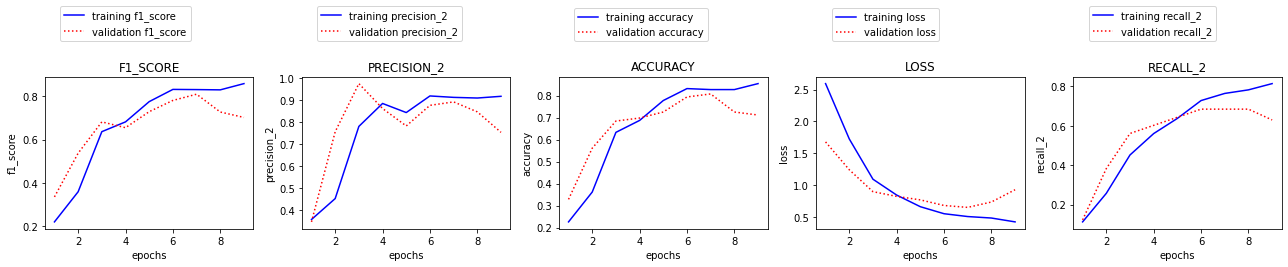

In [ ]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()

## Try2

In [ ]:
# Load the InceptionResNetV2 model with pre-trained weights
input_tensor = tf.keras.layers.Input(shape=(299, 299, 3))
base_model = InceptionV3(weights='imagenet', include_top=False,input_tensor=input_tensor)

# freezen the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a GlobalAveragePooling layer
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = Dense(8, activation='softmax')(x)

# compile the model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
optimizer = tf.keras.optimizers.Nadam(lr=0.002), # ★change
loss='categorical_crossentropy',
              metrics=['accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tfa.metrics. F1Score(num_classes = 8,average='macro')]
                )


In [ ]:
# fit the model
start = perf_counter()
history = model.fit(train_set, epochs = 9, validation_data = val_set) # ★change # ★change # ★change
end = perf_counter()

# print the learning time
print(f"Time : {end-start}")

Epoch 1/9
7/7 [==============================] - 18s 2s/step - loss: 3.2484 - accuracy: 0.1991 - precision_5: 0.2482 - recall_5: 0.1538 - f1_score: 0.1903 - val_loss: 2.0913 - val_accuracy: 0.2740 - val_precision_5: 0.7778 - val_recall_5: 0.0959 - val_f1_score: 0.1854
Epoch 2/9
7/7 [==============================] - 12s 2s/step - loss: 1.7325 - accuracy: 0.4163 - precision_5: 0.5000 - recall_5: 0.1267 - f1_score: 0.4147 - val_loss: 1.3395 - val_accuracy: 0.5616 - val_precision_5: 1.0000 - val_recall_5: 0.2603 - val_f1_score: 0.4730
Epoch 3/9
7/7 [==============================] - 12s 2s/step - loss: 1.1933 - accuracy: 0.6244 - precision_5: 0.8861 - recall_5: 0.3167 - f1_score: 0.6213 - val_loss: 1.1456 - val_accuracy: 0.6301 - val_precision_5: 0.8485 - val_recall_5: 0.3836 - val_f1_score: 0.6265
Epoch 4/9
7/7 [==============================] - 12s 2s/step - loss: 0.8975 - accuracy: 0.7104 - precision_5: 0.8852 - recall_5: 0.4887 - f1_score: 0.7112 - val_loss: 0.9312 - val_accuracy: 0.6

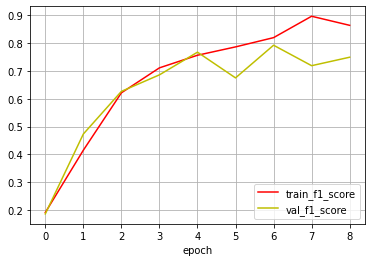

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history[str(list(history.history.keys())[4])] , "r", label='train_f1_score')
plt.plot(history.history[str(list(history.history.keys())[9])] , "y", label='val_f1_score')

plt.xlabel('epoch')

plt.legend(loc='lower right')
plt.grid()
plt.show()

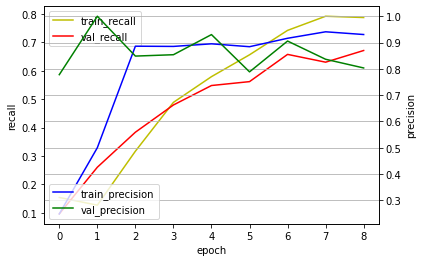

In [ ]:

fig, f1 = plt.subplots()

prec = f1.twinx()

f1.plot(history.history[str(list(history.history.keys())[3])], 'y', label='train_recall') #3
f1.plot(history.history[str(list(history.history.keys())[8])], 'r', label='val_recall') #8

prec.plot(history.history[str(list(history.history.keys())[2])], 'b', label='train_precision') #2
prec.plot(history.history[str(list(history.history.keys())[7])], 'g', label='val_precision') #-3

f1.set_xlabel('epoch')
f1.set_ylabel('recall')
prec.set_ylabel('precision')

f1.legend(loc='upper left')
prec.legend(loc='lower left')

plt.grid()
plt.show()

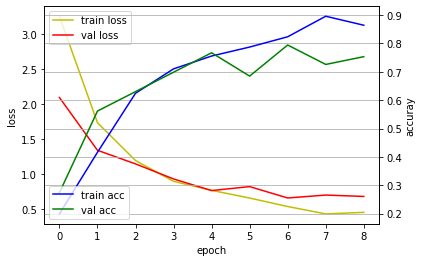

In [ ]:
import matplotlib.pyplot as plt
fig, loss = plt.subplots()

acc = loss.twinx()

loss.plot(history.history[str(list(history.history.keys())[0])], 'y', label='train loss') #3
loss.plot(history.history[str(list(history.history.keys())[5])], 'r', label='val loss') #8

acc.plot(history.history[str(list(history.history.keys())[1])], 'b', label='train acc') #2
acc.plot(history.history[str(list(history.history.keys())[6])], 'g', label='val acc') #-3

loss.set_xlabel('epoch')
loss.set_ylabel('loss')
acc.set_ylabel('accuray')

loss.legend(loc='upper left')
acc.legend(loc='lower left')

plt.grid()
plt.show()

### Test Set

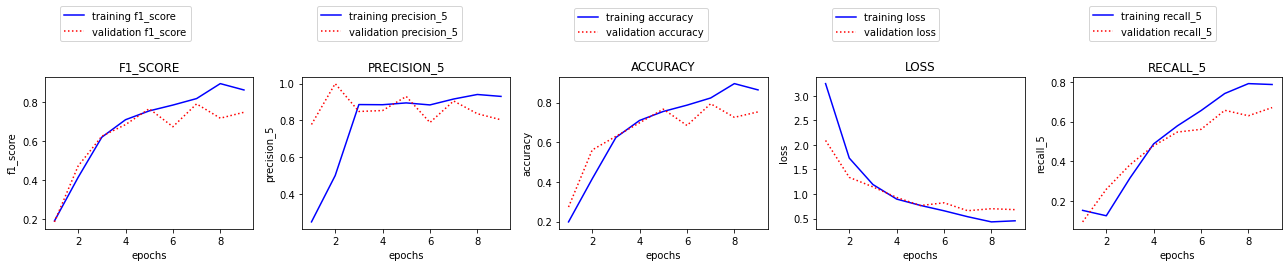

In [ ]:
key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
plt.figure(figsize=(18, 4))
for idx , key in enumerate(key_value) :
    plt.subplot(1, len(key_value), idx+1)

    plt.title(f"{key.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{key.lower()}")
    value = history.history.get(key)
    val_value = history.history.get(f"val_{key}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {key}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {key}')
    plt.legend(loc='lower left', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the test set
result= model.evaluate_generator(test_set) 

print('loss:', round(result[0], 5))
print('accuracy:', round(result[1], 5))
print('precision:', round(result[2], 5))
print('recall:', round(result[3], 5))
print('f1-score:', round(result[4], 5))

<ipython-input-51-c4a14b396fb8>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  result= model.evaluate_generator(test_set)


loss: 0.58007
accuracy: 0.78082
precision: 0.90909
recall: 0.68493
f1-score: 0.77372
